In [1]:
# all imports in one place for convenience
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups_vectorized
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
%matplotlib inline


## 20 Newsgroups Dataset
For this example we will use the 20 newsgroups dataset which can be loaded using scikit-learn's dataset library. The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics.

In [2]:
dataset = fetch_20newsgroups_vectorized()
X, y = dataset.data, dataset.target

Next, we can count the number of instances for each class.

In [3]:
for class_name, class_count  in zip(dataset.target_names, np.bincount(dataset.target)):
    print(class_name, class_count)

alt.atheism 480
comp.graphics 584
comp.os.ms-windows.misc 591
comp.sys.ibm.pc.hardware 590
comp.sys.mac.hardware 578
comp.windows.x 593
misc.forsale 585
rec.autos 594
rec.motorcycles 598
rec.sport.baseball 597
rec.sport.hockey 600
sci.crypt 595
sci.electronics 591
sci.med 594
sci.space 593
soc.religion.christian 599
talk.politics.guns 546
talk.politics.mideast 564
talk.politics.misc 465
talk.religion.misc 377


We see that this is a well-balanced dataset. That is, each class is fairly evenly represented. Unfortunately, we do not always find such evenly distributed data in real life. So to look at the impact of an unbalanced dataset, let us reduce this dataset to just two classes: *sci.space* and everything else. First, make a copy of the target data, then replace all instances of classes that are not *sci.space* with 0, and all instances of *sci.space* with 1.

To see the effect of this change, look at the counts for each class again:

In [4]:
y_2 = y.copy()
y_2[y_2 != 14] = 0
y_2[y_2 == 14] = 1

np.bincount(y_2)

array([10721,   593])

Now we have a dataset that is **class imbalanced**: that is, in the negative class representing posts that are **not** about space, we have 10,721, instances and in the positive class, representing posts about space we only have 593 instances. Now we can train a classifier to predict if a post is about space or not. Let us use the logistic regression classifier.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y_2, random_state=82)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9671261930010604

Not bad! Without any tuning we got an accuracy of 0.967. An accuracy of 96.7% is quite good, but before we celebrate our data science skills, let's examine what this means in the context of an imbalanced dataset.

Suppose we wrote a classifier that did no work at all, did not even look at the features, just simply returned all predictions to be the dominant class. In this case, the dominant class is the negative class. So our dummy classifier will predict the negative class 100% of the time. What is the accuracy of the dummy classifier? Take a moment to think about it.

Recall that 

$$ accuracy = \frac{ \# correct predictions}{all predictions}$$

Since we have 10,721 negative samples, our dummy classifier will be right 10,721 times and wrong 593 times.

$$ accuracy = \frac{10721}{10721 + 593} = 0.94759$$

Still pretty impressive!

Scikit-learn actually has a dummy classifier to help illustrate this exact scenario.

In [6]:
dummy = DummyClassifier(strategy = 'most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)


0.9568752209261223

Remember, the dummy classifier does not actually use the features to make a prediction, it just looks at which class is dominant and returns that one every time. Here, on our test data we get an accuracy of over 95%, almost as good as our real classifier. Given the closeness of these two results, can we really be confident that our classifier is doing such a great job?

This dummy classifier is quite useful for many reasons. It gives a null accuracy baseline to which you can compare your model's performance. This way we know if our classifier is doing better than just a random guess.

If your model's accuracy is close to the null accuracy baseline it might mean that:

 - your features are not good predictors for your problem.
 - your algorithm's parameters may need tuning.
 - you have a large class imbalance.
 
 

## Confusion Matrix
The confusion matrix is simply a table showing every combination of predicted and actual values. It makes it easy to see what type of errors your model is making and allows for the generation of a number of metrics describing the performance of your model. Scikit-learn comes with a function to calculate the confusion matrix given the set of actual values and the set of predictions.

## Why do we use a confusion Matrix?

While it is important to have good accuracy, it does not tell the whole story.  The confusion matrix gives us a deeper understanding of what is going on with our classification model performance by showing us how things are bucketed. It reveals to us which datapoints are bucketed correctly and which ones were not.  

We will explain more about this further in a bit.


In [7]:
predictions = lr.predict(X_test)

confusion = confusion_matrix(y_test, predictions, labels=[1, 0])
print(confusion)

[[  29   93]
 [   0 2707]]


We'll interpret this in a minute.

While this gives us all the information we need, it is not easy to read. To get a prettier picture of the confusion matrix we could use [this function taken from here](https://www.kaggle.com/grfiv4/plot-a-confusion-matrix), or any one of many similar functions you may find on the web.

In [8]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

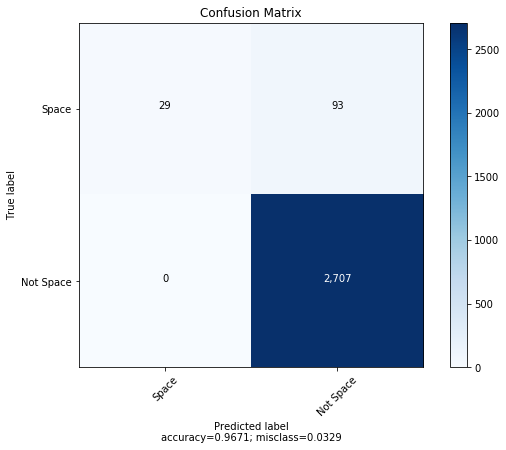

In [9]:
plot_confusion_matrix(cm=confusion, target_names = ['Space', 'Not Space'], title = 'Confusion Matrix',normalize=False)


Notice that the numbers appearing in the boxes of the plot above are the same as in the text-based matrix that scikit-learn produced. But this labeled diagram is much better to look at for visually evaluating a confusion matrix.

### Interpreting the Matrix

But what do the numbers mean? Suppose we trained a binary classification model to recognize images of cats vs no cats.  We build a dataset of images correctly labeled as cats in a photo and other images with no cats. Then we run the model on a labeled test set with several images, some of cats and some with no cats.  Some images are predicted correctly as truly cats in the image, but some of the pictures of cats were falsely bucketed as not a cat.  The reverse can happen where pictures were truely classified as not a cat, but some have slipped through and there was a cat in the photo.  

We could then count the number of times that our model correctly predicted cats, correctly predicted no cats, incorrectly predicted cats and incorrectly predicted no cats. These are the numbers that we plug into the confusion matrix.

From the image above we can define **True Postives (TP)** as the number of of times the model correctly predicts the positive class (cat) and, **True Negatives (TN)** as the number of times the model correctly predicts the negative class (no cat). 

**False Positives (FP)** is the number of times the model incorrectly predicts the positive class and **False Negatives (FN)** is the number of times the model incorrectly predicts the negative class. In statistics false positives are called *Type I errors* and false negatives are called *Type II errors*.

That means the true positive and true negative are the total number of correct predictions, while the false positives and false negatives are the total number of wrong predictions.

There are a number of important metrics that can be calculated from this matrix. First, accuracy:

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN} = \frac{29 + 2707}{29 + 2707 + 0 + 93} = 0.967$$

#### Precision
Precision is a value that tells us what proportion of positive predictions are correct. That is, if the model has a precision of 0.5 then 50% of its positive predictions are correct. Let's calculate the precision of our model.

$$precision = \frac{TP}{TP + FP} = \frac{29}{29 + 0} = 1.0$$

When our model predicts that a post is in the group sci.space it is right only 24% of the time!

Without looking at the precision score, we would have missed this by simply accepting the accuracy score at face value.

#### Recall
Recall is a value that tells us what proportion of positives were correctly predicted. This is a good indication of how many positive instances are being missed.

$$recall = \frac{TP}{TP + FN} = \frac{29}{29 + 93} = 0.24$$

We found 100% of all posts about space.

### Trade-offs 

There is often a trade-off to be made between precision and recall. We may be able to tune our model to improve the precision; that is, make fewer false positive predictions, but it comes at the cost of lower recall. Similarly, if we tune the model to improve the recall then precision may suffer.

There is no one right way to tune your model. You have decide on a case-by-case basis. Given the 20 newsgroups dataset and the model that we trained, are we happy with our precision and recall scores? Well, that depends on how we plan to use this model and the business use case. Suppose we used this model as part of a system that automatically determines a label for new posts, so that we can recommend posts to persons with interest in space.

Given a precision of 24%, more than 75% of the recommendations are going to be wrong. And with a recall of 100%, all posts about space will be correctly identified. Our users may be annoyed because we recommend too many irrelevant posts (false positives). For this scenario, if we improve the precision and make our recommendations more relevant but maybe miss more space posts, our users would be happier.

Now consider a screening test for a particular disease in the population. Suppose we train a model to detect the disease given some symptoms of the patient. If our model predicts positivem, we immediately send the patient for further tests and treatment. If the model predicts false, then we assume the patient is safe. A low precision in this case means that many of the positive cases predicted would turn out to not have the disease. The high recall will mean that most of the positive cases are found. This seems about right. Imagine if the recall were low, many persons with the disease will be incorrectly classified as not having the disease. 

This is a case where recall is more important than precision, because we don't want to let people who need treatment to slip through the cracks (false negatives). 


### F-Score
When evaluating classifiers, it is convenient to combine the precision and recall into a single value called the F1 score. We use the F-score to see how the two metrics level out when combined.

This is done with the following formula:

$$F_1 = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} = \frac{2 \times TP}{2 \times TP + FN + FP}$$

In computing this value the contribution of precision and recall are equal. 

There is a more general case of the F1 score called the F-beta score. To calculate this score a parameter $\beta$ is used to adjust the contribution of recall and precision. To favor precision a value of $\beta < 1$ is used and to favor recall a value of $\beta > 1$ is used. This way if you are building a model where precision is more important that recall then set a value for $\beta$ less than 1. The formula is:

$$F_\beta = (1 + \beta^2) \times \frac{\text{precision} \times \text{recall}}{(\beta^2 \times \text{precision}) + \text{recall}} = \frac{(1 + \beta^2) \times TP}{(1 + \beta^2) \times TP + \beta \times FN + FP}$$

We do not have to perform these calculations by hand. Scikit-learn provides functions in the *sklearn.metrics* library for calculating these values. Each of these functions take the actual target values and the predictions made by the model as input.

In [10]:
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
fbeta_precision = fbeta_score(y_test, predictions, 0.5)
fbeta_recall = fbeta_score(y_test, predictions, 2)

print('Accuracy score: {:.2f}'.format(accuracy))
print('Precision score: {:.2f}'.format(precision))
print('Recall score: {:.2f}'.format(recall))
print('F1 score: {:.2f}'.format(f1))
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))

Accuracy score: 0.97
Precision score: 1.00
Recall score: 0.24
F1 score: 0.38
Fbeta score favoring precision: 0.61
FBeta score favoring recall: 0.28


Notice that the $F_\beta$ score with the $\beta < 1$ scored higher than the $F_\beta$ with $\beta > 1$. This is because we have a higher precision score than recall score. 

The *classification_report* function is also useful giving a summary of these metrics with a single call.

In [19]:
report = classification_report(y_test, predictions, target_names=['Not Space', 'Space'])
print(report)

              precision    recall  f1-score   support

   Not Space       0.97      1.00      0.98      2707
       Space       1.00      0.24      0.38       122

    accuracy                           0.97      2829
   macro avg       0.98      0.62      0.68      2829
weighted avg       0.97      0.97      0.96      2829



We could compare this report to the report on the dummy classifier. The dummy classifier can be used to make predictions in a similar way to a real classifier except we will get all results being the dominant class. We know in this example that the dominant class is the negative class so our dummy classifier will predict 0 instances as the positive class.

In [20]:
dummy_report = classification_report(y_test, dummy.predict(X_test), target_names=['Not Space', 'Space'])
print(dummy_report)

              precision    recall  f1-score   support

   Not Space       0.96      1.00      0.98      2707
       Space       0.00      0.00      0.00       122

    accuracy                           0.96      2829
   macro avg       0.48      0.50      0.49      2829
weighted avg       0.92      0.96      0.94      2829



/Users/karenfarbman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The *UndefinedMetricWarning* is due to the fact that TP + FP == 0. This is a good indication that the classifier is not performing well even though the accuracy is high. Even if our classifier did have a few FP's the precision and recall would be quite low for that class.

## Decision Function - Varying the Probability Threshold
Given some input, the model generates some probabilities for each input. This is given by the *predict_proba()* method. Rather than giving actual predictions, this method gives a probability that this instance belongs to the positive class or not.

In the following code the list of probabilities for the test data is generated and the first 30 values are printed.

In [21]:
probs = lr.predict_proba(X_test)[:, 1]
print(probs[1:30])

[0.01364891 0.05711429 0.03494059 0.03348212 0.02932255 0.02216111
 0.45071078 0.01932676 0.07011708 0.08472435 0.03919031 0.02427247
 0.01909561 0.02652153 0.06818679 0.02653776 0.09209324 0.03810381
 0.01464452 0.02377862 0.02685651 0.05803195 0.03221372 0.02388465
 0.0661609  0.06428845 0.04730358 0.0219367  0.03626409]


We have seen in the previous lesson that the probability threshold is 0.5: that is, if the probability is greater than 0.5 then we will predict positive and if it is less than 0.5 we will predict negative. In the plot below the probabilities of all test samples are plotted in two distribution plots. The red plot is the negative class and the green plot is the positive class. The blue line is the probability threshold. 

Notice that there are positive instances on both sides of the threshold. That means that all positive instances on the left of the threshold will be incorrectly classified as negative giving false negatives. 

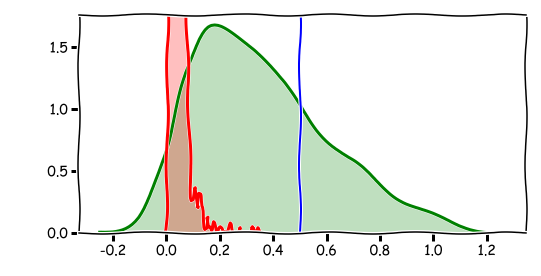

In [22]:
pos = [i for i, j in zip(probs, y_test) if j == 1]
neg = [i for i, j in zip(probs, y_test) if j == 0]

with plt.xkcd():
  fig = plt.figure(figsize=(8, 4))

  sns.distplot(pos, hist = False, kde = True, color='g',
                 kde_kws = {'shade': True, 'linewidth': 3})

  sns.distplot(neg, hist = False, kde = True, color='r',
                 kde_kws = {'shade': True, 'linewidth': 3})

  plt.plot([0.5, 0.5], [0, 25], '-b')
  plt.annotate(
        'The probability threshold\npositive to the right\nnegative to the left',
        xy=(0.51, 15), arrowprops=dict(arrowstyle='->'), xytext=(0.6, 20))

plt.show()

By adjusting the threshold we can affect the recall and precision values. Suppose we wanted to be sure that we got no false positives: that is, we do not want to classify any post as space if it was not about space. We could move the threshold to the right until there are no red instances on the right of the line. That correspondingly will mean that fewer positive instances will be correctly identified. Or, to put it another way, more positive instances will end up on the left of the threshold and will be incorrectly classified as negative.

## ROC curve
If we set the threshold to 0 (moving the threshold all the way to the left) then the model predicts 1 for all samples. We will get a **true positive rate (tpr)** of 1, that is, all positive instances will be correctly predicted. We will also get a **false positive rate (fpr)** of 1 since all negative samples will be incorrectly predicted as positive.

If we set the threshold to 1 then the model predicts 0 for all samples. We get a tpr of 0 since none of the actual positive samples will be correctly predicted and an fpr of 0 because none of the negative class will be predicted as positive.

As we vary the threshold between these two extremes we get different tpr and fpr values. We can plot these values to see the relationship between the values as the threshold moves.

The set of points we get when we vary the threshold from 0 to 1 can be connected to describe a curve through space which is called the **Receiver operating characteristic (ROC)** curve.

The *sklearn.metrics.roc_curve* function calculates the fpr, tpr and threshold values that we can use to plot a ROC curve. Below the first 30 values are printed.

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
print(fpr[1:30])
print(tpr[1:30])
print(thresholds[1:30])

[0.         0.         0.00036941 0.00036941 0.00073883 0.00073883
 0.00110824 0.00110824 0.00147765 0.00147765 0.00184706 0.00184706
 0.00221648 0.00221648 0.00258589 0.00258589 0.00332471 0.00332471
 0.00369413 0.00369413 0.00480236 0.00480236 0.0059106  0.0059106
 0.00628001 0.00628001 0.00664943 0.00664943 0.00775767]
[0.00819672 0.46721311 0.46721311 0.48360656 0.48360656 0.5
 0.5        0.59016393 0.59016393 0.6147541  0.6147541  0.62295082
 0.62295082 0.64754098 0.64754098 0.68852459 0.68852459 0.70491803
 0.70491803 0.74590164 0.74590164 0.7704918  0.7704918  0.77868852
 0.77868852 0.78688525 0.78688525 0.80327869 0.80327869]
[0.98462604 0.3446592  0.34283523 0.3311512  0.32653259 0.32153467
 0.31893541 0.27469392 0.27468563 0.24375424 0.24159574 0.23921165
 0.23860809 0.21948719 0.20223596 0.18165188 0.17696934 0.16373987
 0.16369255 0.15575538 0.15284347 0.1478981  0.13727432 0.13693788
 0.13573329 0.13529207 0.13304517 0.13221123 0.12896697]


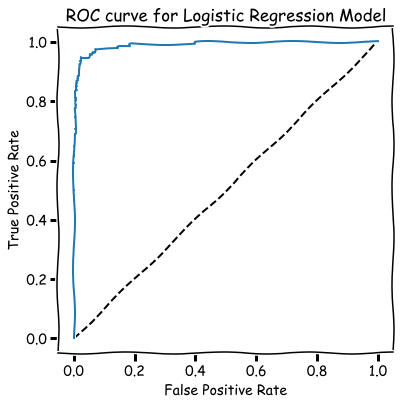

In [24]:
fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic Regression Model')
plt.show()

The top left-hand corner of this graph is the ideal spot: it minimizes the false positive rate and maximizes the true positive rate. So a steep curve that gets close to that corner is better than a shallow curve that remains close to the dashed baseline. That dashed line represents a 50% chance classifier. That is, any classifier that works as well as a coin toss will have a curve close to that line. But that is as good as random. So curves just above that line are better than random. The particular curve for this classifier is quite good as you can see it steeply climbs before leveling out.



## Precision-Recall Curve
Another useful visualization is the precision-recall curve. Similar to the ROC curve it shows the relationship of precision to recall as the threshold is varied from 0 to 1. Again, the sklearn.metrics library provides a function that can help.

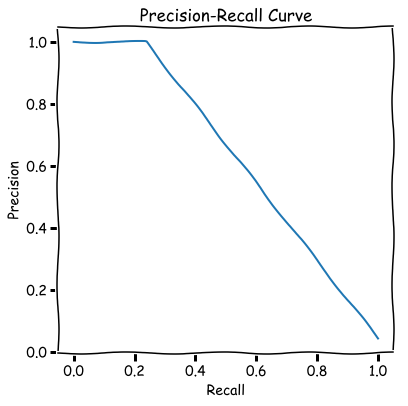

In [25]:
pres, rec, thresholds = precision_recall_curve(y_test, predictions)
fig = plt.figure(figsize = (6, 6))
plt.plot(rec, pres)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In this case, we see a smooth drop in precision as recall increases. We do not always have such a smooth curve but the general downward trend is expected.

Remember that these two visualizations serve slightly different purposes.

 - **ROC curves** are used when the classes are more or less balanced.
 - **Precision-Recall curves** are used when there is a class imbalance.
 
 

## Area under the ROC curve (AUC)
Given the ROC curve can we compute a useful metric from it. Since the top left-hand corner is ideal we want to favor curves that get as close to that corner as possible. If we measure the area under the curve we get a useful metric that tells us how close we get to the ideal. In the plot below we shaded the area under the curve. Notice that if the curve gets closer to the baseline the area will be smaller.



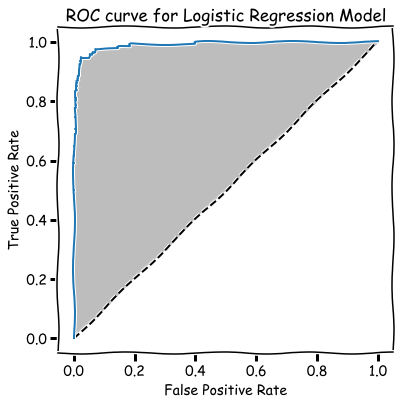

In [26]:
fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.fill(fpr, tpr, 'grey', alpha=0.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic Regression Model')
plt.show()

To calculate the area under the curve (AUC) we use the *roc_auc_score* function from sklearn.metrics. This function takes the actual labels and the predicted probabilities as input.

In [27]:
auc = roc_auc_score(y_test, probs)
print('Area under the ROC curve: {:.3f}'.format(auc))

Area under the ROC curve: 0.990


## Cross Validation
So far we have been using a train-test split to reserve a portion of our data for testing. We do this so that we have some previously unseen data to test the model. If we train and test with the same data we run the risk of overfitting the model to the training data.

But there is still a risk of overfitting to the test data itself. If we tune our model to perform well on the test data, what guarantee do we have that it will continue to perform as well on new data? Also, we know that the training algorithm is susceptible to small changes in the data. Recall from the discussion on linear classifiers that we are searching for a set of parameter values that optimizes a cost function. There is no absolute right answer to such a search. The values we find are dependent on the data that we use to train the model.

By splitting the data into just training and testing, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of sets.

We can see that illustrated by calling train_test_split multiple times and training a model with the results each time. The train_test_split function randomly assigns data to the training set and test set. That means each time you call the function a different set of data is assigned to the test set.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y_2)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
print('First split score: {:.3f}'.format(lr.score(X_test, y_test)))

X_train, X_test, y_train, y_test = train_test_split(X, y_2)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
print('Second split score: {:.3f}'.format(lr.score(X_test, y_test)))

First split score: 0.960
Second split score: 0.955


In the code above train_test_split is called twice and two models are trained with the results. Notice that the accuracy varies between the models. The implication is that we run the risk of randomly selecting a biased training or testing dataset and end up with a model which does not generalize well to unseen data.

That is where cross validation comes in.

Before we explore cross validation, just a quick note about the randomness of train_test_split. If we get a different test set each time, and it results in a different accuracy score each time, how can we know whether any observed improvements are a result of our parameter tuning or just random chance? During model building it would be useful to create a test split that remained stable. To do this we use the **random_state** parameter (which we did at the beginning of this notebook). This parameter takes an integer and uses it as the seed for the random generator. That means you can specify the same number to get the same split each time. In the code below, two models are trained on two splits of the data again, this time with the same **random_state**.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y_2, random_state=40)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
print('First split score: {:.3f}'.format(lr.score(X_test, y_test)))

X_train, X_test, y_train, y_test = train_test_split(X, y_2, random_state=40)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
print('Second split score: {:.3f}'.format(lr.score(X_test, y_test)))

First split score: 0.964
Second split score: 0.964


Now back, to **cross validation**. Cross validation works by dividing the dataset into a specified number (k) of distinct sets called **folds**. Typically k = 5 or 10 folds, but you are free to use any number of folds that you wish. We then iterate the folds and train a model with k - 1 folds and use the remaining fold as the test set for validation. In each iteration, a different fold is used as the test set.

This yields k accuracy scores for the k models that are created and trained. But, each model was trained on a different set of data and tested on a different set of data. Also, each data sample has a chance to be in the test set for one model. We can then find the mean of the scores to get an overall value for our model. 

The **sklearn.model_selection.cross_val_score** function performs this cross validation process providing an array of scores for each model created. Remember that this may be an expensive (in terms of time) process since you have to create and train k different models. Typically you first split the data into the training and test set using *train_test_split* as we did above and cross validation is done on the training set, while the test set is held for final evaluation of the selected model.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y_2, random_state=40)
clf = LogisticRegression(solver='lbfgs')
cv_scores = cross_val_score(clf, X_train, y_train, cv = 5)

print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validatiion score: {:.3f}'.format(np.mean(cv_scores)))

Accuracy scores for the 5 folds:  [0.95167943 0.96169711 0.95816146 0.95639364 0.95875074]
Mean cross validatiion score: 0.957


Based on the scores, the model is able to predict consistently high on all 5 folds of the dataset.  This gives us assurance that the model is performing well on unseen data multiple times and it was not just by luck of the draw during the initial data split.


# Conclusion:

Accuracy score does not tell the whole story, so we use a variety of techniques to have a better understanding of how our classification model is performing.  

With the different evaluation metrics presented, we can identify where the model is misclassifying and use this information to improve the model on further iterations.  

We also want to consider trade-offs to better focus our time and energy for the next model iteration.  How the model will be used will drive those decisions.  

We can now use the various model evaluation techniques described above along with cross validation to select the best performing model for our next project.